<a href="https://colab.research.google.com/github/Biglasagna/Repo_test/blob/main/Projet_Diabete_UE_Bioinfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Proposition d'un modèle de deep learning pour la classification patients/contrôles pour le diabète de type 2 à partir de données transcriptomiques
---


# introduction

Face à la recrudescence de données génomiques et cliniques, les nouveaux algorithmes de Deeplearning s'imposent comme l'état de l'art en terme de prédiction et efficacité. Qu'ils soient utilisés pour la prédiction de séquences protéiques (Alphafold ...), génomiques (Evo2 ...), ou encore aident les practiciens dans l'analyse de résultats sanguins ou de radiologie, la capacité d'entrainement sur données réelles, leur précision et leur vitesse en fait un allié de choix pour les chercheurs aujourd'hui.

Nous proposons ici l'utilisation d'un réseau de neurones simple (ou "fully connected feedforward neural network"), également appelé Perceptron Multicouche (MLP, Multilayer Perceptron) dans la prévision de l'état contrôle/patient à partir de données transcriptomiques.

Les données proviennent de séquençage RNAseq sur des cellules pancréatiques de patients et contrôles trouvée en libre accès sur GEO.

### Etapes :

* Import des données
* Préparation des données pour être utilisées
* Création du modèle et entrainement
* Visualisation de l'entrainement
* Visualisation des résultats de test et validation

## Chargement des données de l'environnement local vers le drive pour un accès en ligne.




In [ ]:
import os
import pandas as pd
import io

# Monter le drive Google (ceci vous demandera d'autoriser l'accès à votre compte)
from google.colab import drive
drive.mount('/content/drive')

# Installer la bibliothèque gdown si ce n'est pas déjà fait
!pip install -q gdown

import gdown

# Extraction de l'ID du fichier depuis l'URL
file_id = '17UIROFJVhc-4sMv9BSEvQ8A7HCI-0kkt'
# Construction de l'URL de téléchargement direct
url = f'https://drive.google.com/uc?id={file_id}'

# Spécifier le chemin de sauvegarde sur le drive personnel
output_path = '/content/drive/MyDrive/GSE81608_human_islets_rpkm (1).txt'

# Vérifier si le fichier existe déjà
if not os.path.exists(output_path):
    print("Téléchargement en cours...")
    gdown.download(url, output_path, quiet=False)
else:
    print("Le fichier existe déjà. Téléchargement annulé.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Le fichier existe déjà. Téléchargement annulé.


In [31]:
import pandas as pd
from google.colab import drive

# Step 1: Mount Google Drive to Colab
drive.mount('/content/drive')

# Step 2: Define the path to the file in Google Drive
file_path = '/content/drive/MyDrive/GSE81608_human_islets_rpkm (1).txt'

# Step 3: Load the file into a pandas DataFrame
data = pd.read_csv(file_path, sep='\t')  # Load the file with tab separator
print(data.head(3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   gene.id  Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  \
0        1   47.3396   24.0458    2.2743       0.0       0.0       0.0   
1        2    0.0000    0.0000    0.0000       0.0       0.0       0.0   
2        3    0.0000    0.0000    0.0000       0.0       0.0       0.0   

   Sample_7  Sample_8  Sample_9  ...  Sample_1591  Sample_1592  Sample_1593  \
0       0.0     0.000       0.0  ...          0.0       0.3304       2.4857   
1       0.0     0.254       0.0  ...          0.0       0.0000       0.0000   
2       0.0     0.000       0.0  ...          0.0       0.0000       0.0000   

   Sample_1594  Sample_1595  Sample_1596  Sample_1597  Sample_1598  \
0          0.0       8.1498          0.0       0.5372      31.1225   
1          0.0       0.0000          0.0       0.0000       0.0000   
2          0.0       0.0000          0.0       

## Transformation des données pour garder les "features" (ici les gènes) en colonnes et les individus en ligne, format sur lequel les librairies de deep learning sont basées. Création de la colonne "Label" pour la supervisation de l'apprentissage (0 pour contrôles et 1 pour patients).

In [32]:
# Définir 'gene.id' comme index
data.set_index('gene.id', inplace=True)

data_transposed = data.T  # Transpose the DataFrame
data_transposed['Label'] = [0 if i < 653 else 1 for i in range(len(data_transposed))]

# Verify the transposed data
print(data_transposed.head())

gene.id         1    2    3         9   10   11       12   13        14   15  \
Sample_1  47.3396  0.0  0.0    0.0000  0.0  0.0   0.0000  0.0   31.2047  0.0   
Sample_2  24.0458  0.0  0.0    0.0000  0.0  0.0  14.0425  0.0    0.0000  0.0   
Sample_3   2.2743  0.0  0.0    0.0000  0.0  0.0   0.8412  0.0    7.8214  0.0   
Sample_4   0.0000  0.0  0.0    0.0000  0.0  0.0   0.0000  0.0    0.0000  0.0   
Sample_5   0.0000  0.0  0.0  130.9796  0.0  0.0   0.0000  0.0  120.6832  0.0   

gene.id   ...  101929767  101929768  101929769  101929770  101929771  \
Sample_1  ...     5.1983        0.0        0.0        0.0        0.0   
Sample_2  ...     0.1064        0.0        0.0        0.0        0.0   
Sample_3  ...     0.3188        0.0        0.0        0.0        0.0   
Sample_4  ...     0.0000        0.0        0.0        0.0        0.0   
Sample_5  ...     0.0000        0.0        0.0        0.0        0.0   

gene.id   101930100  102723951  102724004  102724238  Label  
Sample_1       0.00     

## Sur les 40 000 gènes testés par la puce, on ne garde que les 8000 les plus significativement différentiellements exprimés. Pour cela on divise le jeu de données en 2 selon le label pour y effectuer les tests statistiques et ne garder que les gènes avec la meilleure p-value. Pour les gènes dont la distribution parmis les échantillons suit une loi normale on applique le test T (vérification de la normalité avec test de shapiro) et test non paramétrique de Mann Whitney sinon.

In [33]:

import numpy as np
from scipy.stats import ttest_ind, shapiro, mannwhitneyu

# Separate patients and controls
patients = data_transposed[data_transposed['Label'] == 1]  # Samples with label 1 (patients)
controls = data_transposed[data_transposed['Label'] == 0]  # Samples with label 0 (controls)

# Remove the 'Label' column for statistical testing
patients = patients.drop(columns=['Label'])
controls = controls.drop(columns=['Label'])

# Initialize a dictionary to store p-values
p_values = {}

# Perform t-test or Mann-Whitney U test for each gene based on normality
for gene in patients.columns:
    # Check normality for patients and controls
    _, p_patients = shapiro(patients[gene].dropna())  # Drop NaN values for the test
    _, p_controls = shapiro(controls[gene].dropna())  # Drop NaN values for the test

    # If both groups are normally distributed, perform t-test
    if p_patients > 0.05 and p_controls > 0.05:
        t_stat, p_val = ttest_ind(patients[gene], controls[gene], nan_policy='omit')
    else:
        # If not normally distributed, perform Mann-Whitney U test
        _, p_val = mannwhitneyu(patients[gene], controls[gene], nan_policy='omit')

    p_values[gene] = p_val

# Convert p-values to a pandas Series for easier manipulation
p_values_series = pd.Series(p_values)

# Sort genes by p-value (ascending order)
sorted_p_values = p_values_series.sort_values()

# Select the top N genes with the smallest p-values (e.g., top 1000)
top_genes = sorted_p_values.head(8000).index  # Adjust the number as needed

# Filter the original dataset to keep only the top differentially expressed genes
filtered_data = data_transposed[top_genes]

# Add the 'Label' column back to the filtered dataset
filtered_data['Label'] = data_transposed['Label']

print(f"Filtered dataset shape: {filtered_data.shape}")

print(filtered_data.head(5))


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Filtered dataset shape: (1600, 8001)
gene.id   100128906  285045  100302254  645693   441032     1487  100462954  \
Sample_1   435.6070  0.3046     0.0000  3.5314  19.4823   1.1258     0.0000   
Sample_2   825.3685  0.2094    46.4375  1.6993  36.1608   3.6117     8.8829   
Sample_3   669.6670  0.2508    13.9082  2.0358  40.9145   3.4615     2.6605   
Sample_4   557.6585  0.1556     7.8439  0.5741  15.8355   9.0289     7.5022   
Sample_5   500.9827  0.0778    43.1359  3.9463   9.9525  29.1880     4.1257   

gene.id   100873254  728081    146110  ...    7165      9532  391037     3035  \
Sample_1    30.5348  0.1538   42.6128  ...  0.0000    0.0000  0.0302  19.0919   
Sample_2   305.6264  0.1480  126.7619  ...  0.9659  162.2157  0.0000  15.7495   
Sample_3   341.5011  0.0443  122.8302  ...  0.0000    0.0000  0.0000   3.4592   
Sample_4   339.5268  0.0667   44.0827  ...  2.2840   10.7700  0.0000   0.8868   
Sample_5   395.8177  0.0229  124.6757  ...  0.0000    7.8390  0.0000   0.0000   

g

<ipython-input-33-3f9cb132a658>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Label'] = data_transposed['Label']


## Création du réseau de neurones.
Le modèle après entrainement est stocké sous le nom `model` et peut alors être exporté


Epoch [1/15], Loss: 0.7026, Val Loss: 0.5146, Val Accuracy: 76.56%
Epoch [2/15], Loss: 0.4336, Val Loss: 0.4579, Val Accuracy: 78.12%
Epoch [3/15], Loss: 0.3083, Val Loss: 0.4188, Val Accuracy: 78.75%
Epoch [4/15], Loss: 0.2219, Val Loss: 0.3858, Val Accuracy: 78.75%
Epoch [5/15], Loss: 0.1644, Val Loss: 0.3574, Val Accuracy: 81.25%
Epoch [6/15], Loss: 0.1252, Val Loss: 0.3331, Val Accuracy: 82.81%
Epoch [7/15], Loss: 0.0972, Val Loss: 0.3128, Val Accuracy: 84.69%
Epoch [8/15], Loss: 0.0765, Val Loss: 0.2964, Val Accuracy: 85.62%
Epoch [9/15], Loss: 0.0608, Val Loss: 0.2830, Val Accuracy: 85.94%
Epoch [10/15], Loss: 0.0486, Val Loss: 0.2722, Val Accuracy: 85.62%
Epoch [11/15], Loss: 0.0389, Val Loss: 0.2636, Val Accuracy: 85.62%
Epoch [12/15], Loss: 0.0313, Val Loss: 0.2566, Val Accuracy: 86.56%
Epoch [13/15], Loss: 0.0253, Val Loss: 0.2508, Val Accuracy: 87.50%
Epoch [14/15], Loss: 0.0206, Val Loss: 0.2461, Val Accuracy: 88.44%
Epoch [15/15], Loss: 0.0168, Val Loss: 0.2422, Val Accura

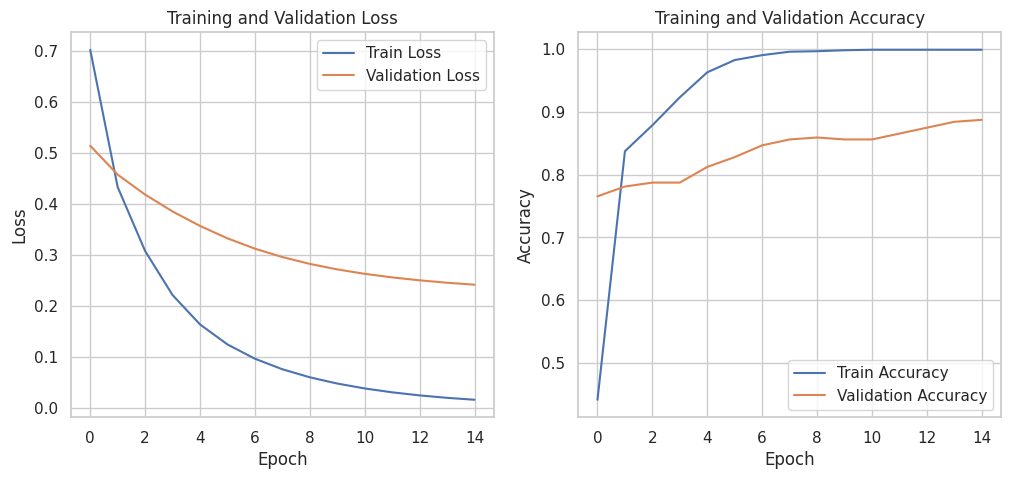

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import random

# --- Fixer la seed pour la reproductibilité ---

seed = 42  # Vous pouvez choisir n'importe quelle valeur pour la seed

# Seed pour PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Si vous utilisez plusieurs GPU

# Seed pour NumPy
np.random.seed(seed)

# Seed pour Python
random.seed(seed)


# --- Préparation des données ---

X = filtered_data.drop(columns=['Label']).values  # On enlève les labels des données et on les met dans la variable y
y = filtered_data['Label'].values  # Labels

# Standardisation des features (important pour les réseaux de neurones)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Séparation en ensembles d'entraînement et de validation (80%-20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

# Conversion en tenseurs PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# --- Définition du modèle ---

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Lancement de la fonction

input_size = X_train.shape[1]   # 8000 features
hidden_size = 64                # Taille de la couche cachée
output_size = 1                 # Classification binaire
model = SimpleNN(input_size, hidden_size, output_size)

# Entraînement du modèle ---

criterion = nn.BCELoss()  # Fonction de perte (binary cross-entropy), n'est pas la seule qui existe
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimiser Adam pour l'ajustement des poids

# Listes pour stocker les valeurs de perte et d'accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Entrainement du modèle n fois, stockage des données d'entrainemnent
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass et optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Stocker la perte d'entraînement
    train_losses.append(loss.item())

    # Calcul de l'accuracy sur l'entraînement
    y_train_pred = (outputs > 0.5).float()
    train_accuracy = (y_train_pred == y_train).float().mean()
    train_accuracies.append(train_accuracy.item())

    # Evaluation sur le set de validation
    with torch.no_grad():
        model.eval()
        y_pred = model(X_val)
        val_loss = criterion(y_pred, y_val)
        val_losses.append(val_loss.item())

        y_pred_class = (y_pred > 0.5).float()
        accuracy = (y_pred_class == y_val).float().mean()
        val_accuracies.append(accuracy.item())

    # Affichage de l'epoch courante
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy.item() * 100:.2f}%')

# --- Affichage des courbes d'entraînement ---
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [35]:
# Récupérer les poids de la première couche (fc1)
weights_fc1 = model.fc1.weight.data  # Shape: (hidden_size, input_size)

# Récupérer les poids de la couche de sortie (fc2)
weights_fc2 = model.fc2.weight.data  # Shape: (output_size, hidden_size)

# Convertir en numpy pour faciliter les calculs
weights_fc1 = weights_fc1.numpy()
weights_fc2 = weights_fc2.numpy()

# Calculer la contribution des features à la classe 1 (malade)
# On multiplie les poids de fc1 par les poids de fc2 associés à la classe 1
# Note: Puisque output_size = 1, weights_fc2 a une seule ligne
feature_contributions = np.abs(weights_fc1.T @ weights_fc2.T).flatten()

# Récupérer les noms des features (supposons que feature_names est une liste de noms de gènes)
feature_names = filtered_data.drop(columns=['Label']).columns

# Trier les features par leur contribution (ordre décroissant)
sorted_indices = np.argsort(feature_contributions)[::-1]
sorted_feature_contributions = feature_contributions[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Sélectionner les top n features
top_n = 100
top_feature_contributions = sorted_feature_contributions[:top_n]
top_feature_names = sorted_feature_names[:top_n]


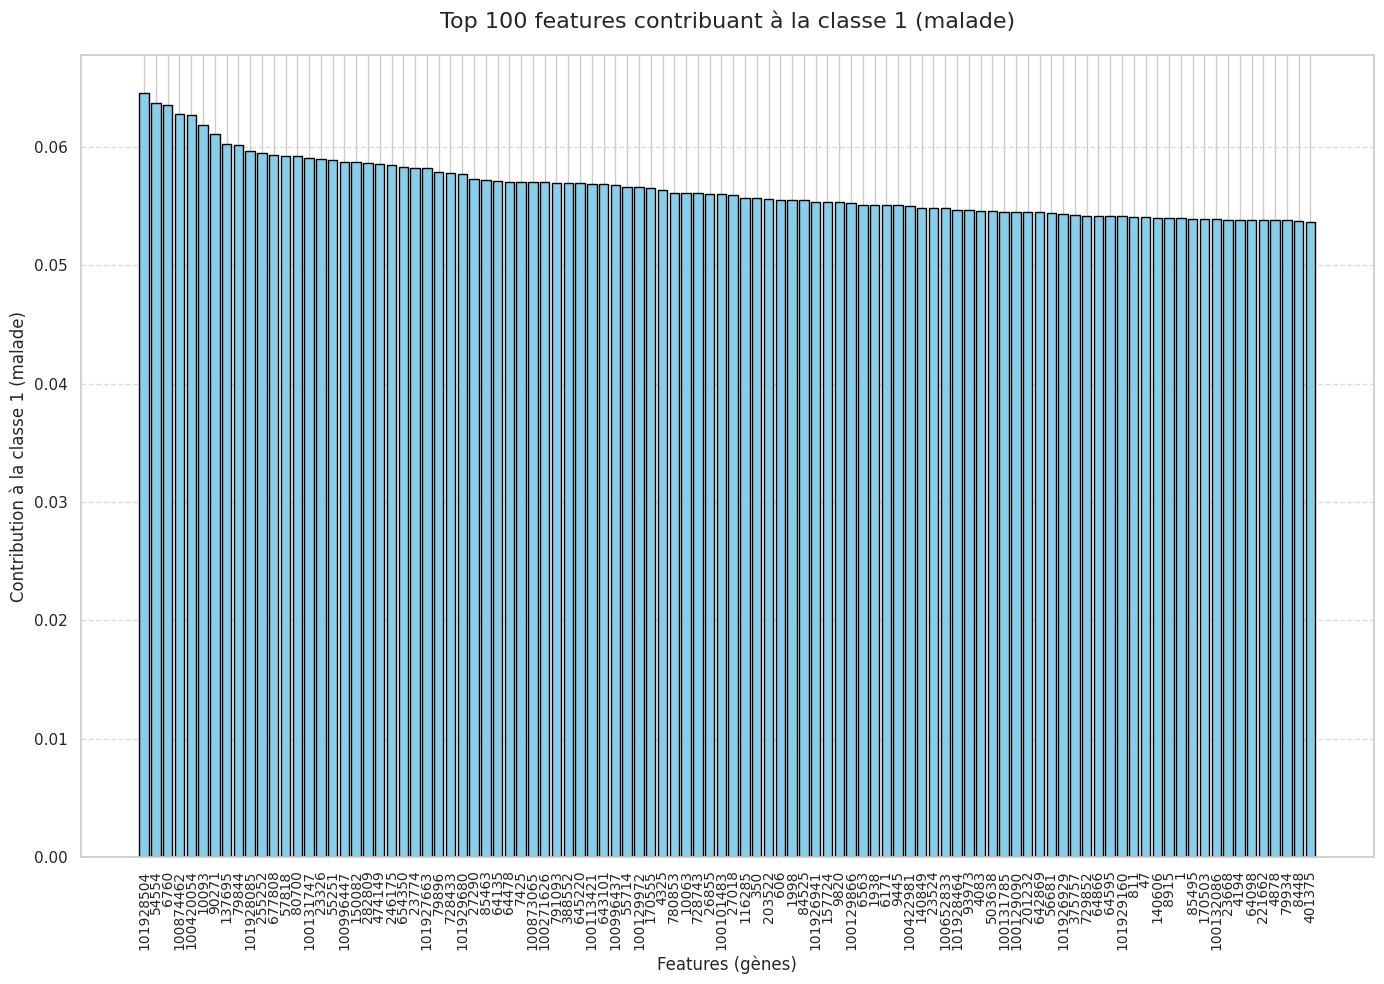

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Paramètres pour le style du graphique
plt.figure(figsize=(14, 10))  # Taille du graphique

# Créer le barplot avec des barres VERTICALES
plt.bar(range(top_n), top_feature_contributions, color='skyblue', edgecolor='black')

# Ajouter les noms des features sur l'axe X
plt.xticks(range(top_n), top_feature_names, fontsize=10, rotation=90)  # Rotation pour lisibilité

# Ajouter des labels et un titre
plt.ylabel('Contribution à la classe 1 (malade)', fontsize=12)
plt.xlabel('Features (gènes)', fontsize=12)
plt.title(f'Top {top_n} features contribuant à la classe 1 (malade)', fontsize=16, pad=20)

# Ajouter une grille pour une meilleure lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajuster la mise en page pour éviter que les labels ne soient coupés
plt.tight_layout()

# Afficher le graphique
plt.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


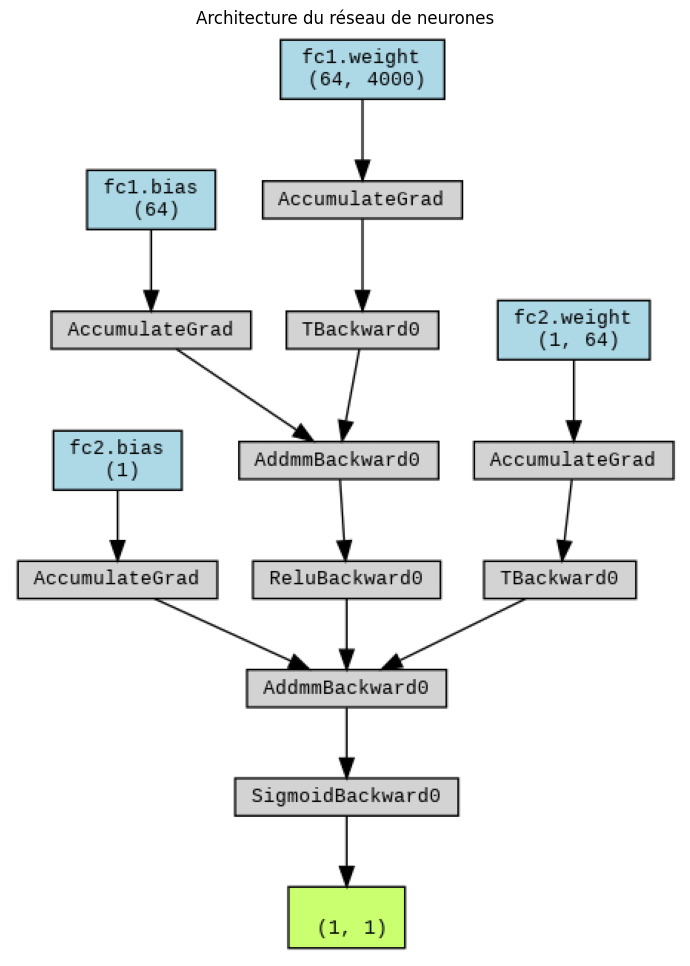

In [ ]:
# --- Visualisation du réseau de neurones ---

  # Installer torchviz et graphviz (nécessaire pour générer et afficher le graphe)
!pip install torchviz
!apt-get install graphviz -y

from torchviz import make_dot

  # Création d'une entrée d'exemple (un seul échantillon)
sample_input = X_train[0].unsqueeze(0)  # Passage d'une dimension batch
sample_output = model(sample_input)

  # Générer le graphe computationnel du modèle
graph = make_dot(sample_output, params=dict(model.named_parameters()))
graph.render("model_architecture", format="png")  # Enregistrement du graphe sous "model_architecture.png"

  # Afficher l'image directement dans le notebook
import matplotlib.image as mpimg
img = mpimg.imread('model_architecture.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.title("Architecture du réseau de neurones")
plt.show()